# Experiments and results

### imports

In [1]:
from utils import lmo_fro, lmo_spectral, prox_l1, grad_gb, prox_mcp, spectral_prox_l1, mcp, mcp_torch
from BCD import load_dataset, Hadamard_BCD

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import torch

from tqdm import tqdm

from problems import generateWH, run_MoreauNSD, run_VS, run_subgradient_descent

import seaborn as sns
sns.set_theme('paper', 'whitegrid')

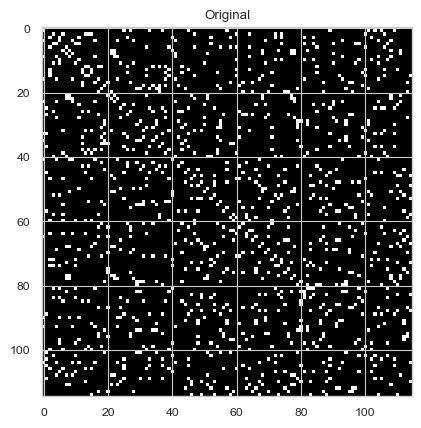

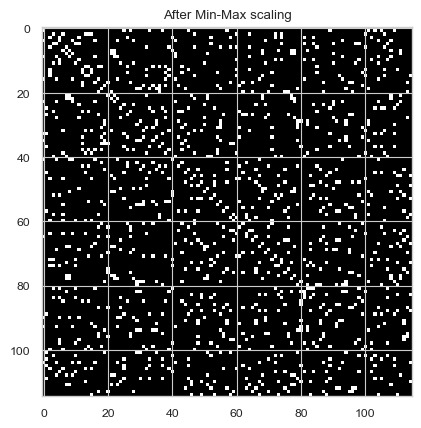

(115, 115)


In [ ]:
# D = load_dataset("synthetic", m = 500, n = 500)
# D = load_dataset("olivetti")
# D = load_dataset("camera")
# D = load_dataset("spectrometer")
# D = load_dataset("football")
# D = load_dataset("miserables")
# D = load_dataset("low_rank_synthetic")
# from scipy.linalg import svd
img = plt.imshow(D)
plt.title('Original')
img.set_cmap('gray')
plt.show()

# Min-Max Scaling
# Apply to each column (axis=0)
min_vals = D.min()
max_vals = D.max()

D = (D - min_vals) / (max_vals - min_vals)

plt.title('After Min-Max scaling')
img = plt.imshow(D)
img.set_cmap('gray')
plt.show()

# # Normalization
# D /= np.linalg.norm(D, 'fro')
# plt.title('After normalization')
# plt.imshow(D)
# plt.show()

print(D.shape)

## Experiments with rank = 10

### Run algorithms

In [ ]:
rank = 10
# m = 200
# n = 1000
# W1, H1, W2, H2, error, times = Hadamard_BCD(D, r=rank, maxiter= 10)

# W = W1*W2
# H = H1*H2
# W, H = generateWH(m, n, rank)
# D = W@H
# plt.imshow(D)
# F_min = np.linalg.norm(W, 1)
# def g(W):
#     s = svd(W, compute_uv=False)
#     # S = np.zeros((m,rank))
#     # for i in range(len(s)):
#     #     S[i, i] = np.abs(s[i])
#     return np.sum(np.abs(s))# U@S@Vt

g = lambda W : np.sum(mcp(W))
g_torch = lambda W : torch.sum(mcp_torch(W))

print(D.shape)
m, n = D.shape
norm_D = np.linalg.norm(D, 'fro')**2
print(norm_D)
# D /= norm_D

F_min = g(D)
K = 5_000

prox = prox_mcp
# prox = spectral_prox_l1
# prox = prox_l1


loss_NSD, dist_W_prox_NSD, WHs_NSD = run_MoreauNSD(D, rank, prox, max_iter = K)
loss_NSD2, dist_W_prox_NSD2, WHs_NSD2 = run_MoreauNSD(D, rank, prox, max_iter = K, p = 7/12, q = 1/3)
loss_NSD3, dist_W_prox_NSD3, WHs_NSD3 = run_MoreauNSD(D, rank, prox, max_iter = K, p = 1/2, q = 1/2)
loss_NSD4, dist_W_prox_NSD4, WHs_NSD4 = run_MoreauNSD(D, rank, prox, max_iter = K, p = 1/3, q = 1/2)
loss_sub, _, WHs_sub = run_subgradient_descent(D, g_torch,((m, rank), (rank, n)), max_iter = K)
# loss_cvxNSD, dist_W_prox_cvxNSD, WHs_cvxNSD = run_cvxMoreauNSD(D, rank, prox, max_iter = K)

# plt.scatter(np.arange(len(loss))[::50], loss[::50]/norm_D, label = 'GAMONS', marker="v")

# loss = run_MoreauNSD(D, 10, lmo = lmo_fro)
# plt.loglog(loss/norm_D, label = 'l2 lmo')

loss_VS, dist_W_prox_VS, WHs_VS = run_VS(D, rank, prox, max_iter = K)


(115, 115)
1226.0000000000002


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<00:00, 13167.88it/s]


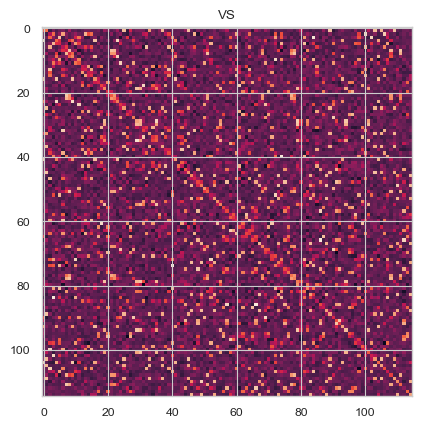

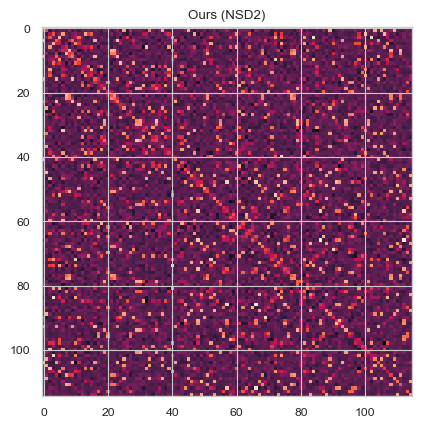

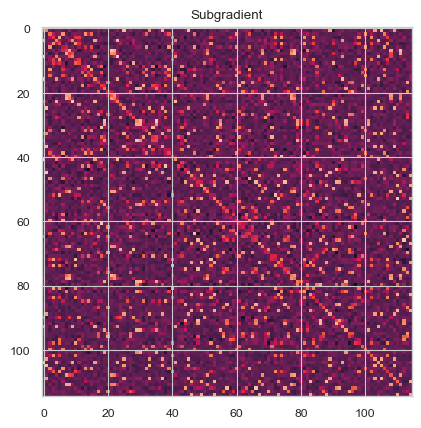

In [30]:
# fig, ax = plt.subplots(1, 3)
plt.imshow(D)
plt.title('Original')

W, H = WHs_NSD[-1]
plt.imshow(norm_D*W@H)
plt.title('Ours')

W, H = WHs_VS[-1]
plt.imshow(W@H)
plt.title('VS')
plt.show()
# W, H = WHs_cvxNSD[-1]
# ax[3].imshow(norm_D*W@H)
# ax[3].set_title('Ours (CVX MNSD)')
W, H = WHs_NSD2[-1]
plt.imshow(norm_D*W@H)
plt.title('Ours (NSD2)')
plt.show()

W, H = WHs_sub[-1]
plt.imshow(norm_D*W@H)
plt.title('Subgradient')
plt.show()

In [5]:
W, H = WHs_NSD[-1]
s = svd(W, compute_uv=False)
print(s)
print(s.sum())
W, H = WHs_NSD2[-1]
s = svd(W, compute_uv=False)
print(s)
print(s.sum())
W, H = WHs_VS[-1]
s = svd(W, compute_uv=False)
print(s)
print(s.sum())

[0.29945505 0.26204346 0.25094026 0.24492771 0.23793168 0.23109946
 0.22332512 0.21722635 0.20445358 0.19244476]
2.363847442347118
[0.23939245 0.20769832 0.20411509 0.19318712 0.19026224 0.18794284
 0.17896479 0.17262587 0.16688988 0.15326076]
1.8943393700526383
[0.2659821  0.22024205 0.2093277  0.19713918 0.19281629 0.18967284
 0.18740611 0.18291212 0.17678904 0.1697025 ]
1.9919899313569112


### Plots

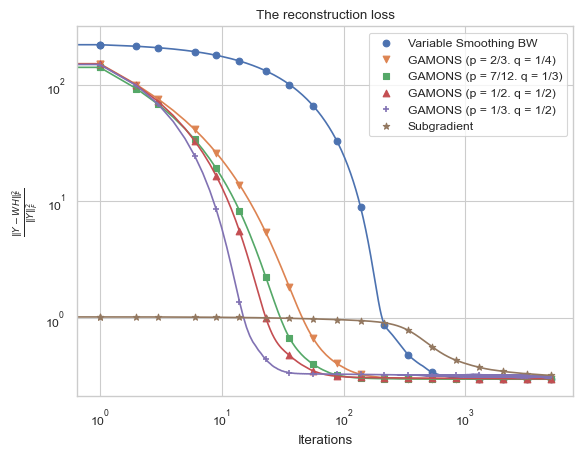

In [41]:
scatter_period = K // 20

# x = np.arange(len(loss_VS))[::scatter_period]
x = np.logspace(0, np.log10(len(loss_VS)), num=len(x), endpoint=True).astype(int)

plt.loglog(loss_VS/norm_D)
plt.scatter(x, loss_VS[x]/norm_D, label = 'Variable Smoothing BW', marker="o")

plt.loglog(loss_NSD/norm_D)
plt.scatter(x, loss_NSD[x]/norm_D, label = 'GAMONS (p = 2/3. q = 1/4)', marker="v")

plt.loglog(loss_NSD2/norm_D)
plt.scatter(x, loss_NSD2[x]/norm_D, label = 'GAMONS (p = 7/12. q = 1/3)', marker="s") 

plt.loglog(loss_NSD3/norm_D)
plt.scatter(x, loss_NSD3[x]/norm_D, label = 'GAMONS (p = 1/2. q = 1/2)', marker="^")  

plt.loglog(loss_NSD4/norm_D)
plt.scatter(x, loss_NSD4[x]/norm_D, label = 'GAMONS (p = 1/3. q = 1/2)', marker="+")

plt.loglog(loss_sub/norm_D)
plt.scatter(x, loss_sub[x]/norm_D, label = 'Subgradient', marker="*")
# plt.ylim(1e-3, 1e1)


# plt.loglog(loss_cvxNSD/norm_D)
# plt.scatter(np.arange(len(loss_cvxNSD))[::scatter_period], loss_cvxNSD[::scatter_period]/norm_D, label = 'Acc GAMONS', marker="^")
# plt.loglog(loss/norm_D)
# plt.scatter(np.arange(len(loss))[::50], loss[::50]/norm_D, label = 'GAMONS', marker="v")
# plt.loglog(loss/norm_D)
# plt.scatter(np.arange(len(loss))[::50], loss[::50]/norm_D, label = 'GAMONS', marker="v")
# W1, H1, W2, H2, error, times = Hadamard_BCD(D, r=rank, maxiter= K)
# print(len(error))
# plt.loglog(error)
# plt.scatter(np.arange(len(error))[::50], error[::50], label = 'BCD', marker="^")

plt.ylabel(r'$\frac{\|Y - WH\|_F^2}{\|Y\|_F^2}$')
plt.xlabel('Iterations')
plt.title('The reconstruction loss')


plt.legend()
plt.show()
    

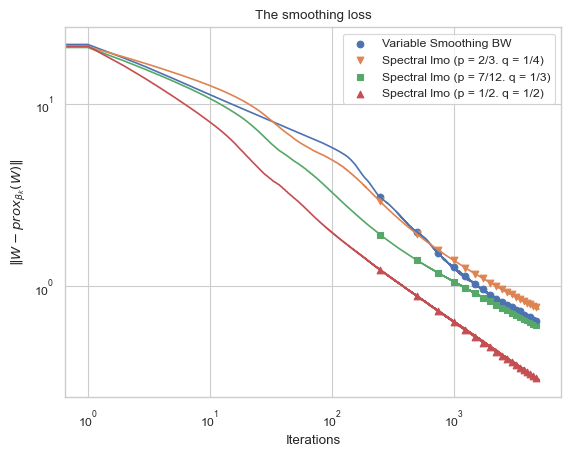

In [ ]:
plt.loglog(dist_W_prox_VS)
plt.scatter(np.arange(len(dist_W_prox_VS))[::scatter_period], dist_W_prox_VS[::scatter_period], label = 'Variable Smoothing BW', marker="o")

plt.loglog(dist_W_prox_NSD)
plt.scatter(np.arange(len(dist_W_prox_NSD))[::scatter_period], dist_W_prox_NSD[::scatter_period], label = 'GAMONS (p = 2/3. q = 1/4)', marker="v")

plt.loglog(dist_W_prox_NSD2)
plt.scatter(np.arange(len(dist_W_prox_NSD))[::scatter_period], dist_W_prox_NSD2[::scatter_period], label = 'GAMONS (p = 7/12. q = 1/3)', marker="s")

plt.loglog(dist_W_prox_NSD3)
plt.scatter(np.arange(len(dist_W_prox_NSD3))[::scatter_period], dist_W_prox_NSD3[::scatter_period], label = 'GAMONS (p = 1/2. q = 1/2)', marker="^")

plt.ylabel(r'$\|W - prox_{\beta_k}(W)\|$')
plt.xlabel('Iterations')
plt.title('The smoothing loss')

plt.legend()
plt.show()

/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_57898/257632622.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


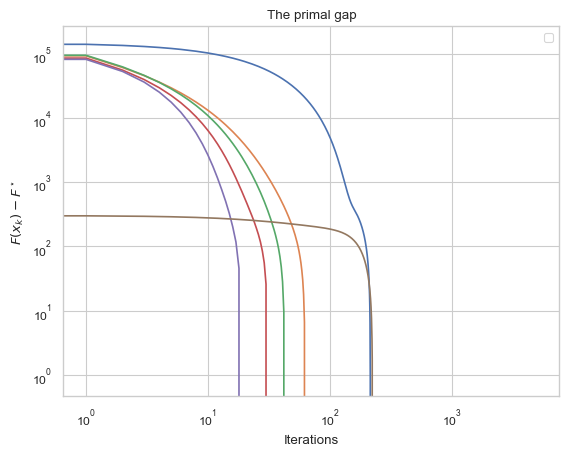

In [ ]:
ls_VS = np.zeros(K+1)
g_VS = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_VS):
    g_VS[i] = g(W)
    ls_VS[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_VS[i] - F_min
plt.loglog(ls_VS)
# plt.scatter(np.arange(len(ls_VS))[::20], ls_VS[::20], label = 'Variable Smoothing BW', marker="o")

ls_NSD = np.zeros(K+1)
g_NSD = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_NSD):
    g_NSD[i] = g(W)
    ls_NSD[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_NSD[i] - F_min
plt.loglog(ls_NSD)  
# plt.scatter(np.arange(len(ls_NSD))[::20], ls_NSD[::20], label = 'GAMONS', marker="v")

ls_NSD2 = np.zeros(K+1)
g_NSD2 = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_NSD2):
    g_NSD2[i] = g(W)
    ls_NSD2[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_NSD2[i] - F_min
plt.loglog(ls_NSD2)
# plt.scatter(np.arange(len(ls_NSD2))[::20], ls_NSD2[::20], label = 'GAMONS', marker="s")

ls_NSD3 = np.zeros(K+1)
g_NSD3 = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_NSD3):
    g_NSD3[i] = g(W)
    ls_NSD3[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_NSD3[i] - F_min
plt.loglog(ls_NSD3)
# plt.scatter(np.arange(len(ls_NSD3))[::20], ls_NSD3[::20], label = 'GAMONS', marker="^")

ls_NSD4 = np.zeros(K+1)
g_NSD4 = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_NSD4):
    g_NSD4[i] = g(W)
    ls_NSD4[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_NSD4[i] - F_min
plt.loglog(ls_NSD4)
# plt.scatter(np.arange(len(ls_NSD4))[::20], ls_NSD4[::20], label = 'GAMONS', marker="+")

ls_sub = np.zeros(K+1)
g_sub = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_sub):
    g_sub[i] = g(W)
    ls_sub[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_sub[i] - F_min
plt.loglog(ls_sub)
# plt.scatter(np.arange(len(ls_sub))[::20], ls_sub[::20], label = 'Subgradient', marker="+")
plt.ylabel(r'$F(x_k) - F^\star$')
plt.xlabel('Iterations')
plt.title('The primal gap')

plt.legend()
plt.show()
    

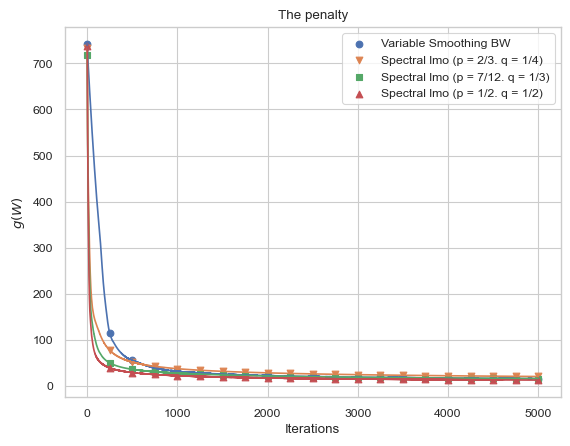

In [ ]:
plt.plot(g_VS)
plt.scatter(np.arange(len(g_VS))[::scatter_period], g_VS[::scatter_period], label = 'Variable Smoothing BW', marker="o")

plt.plot(g_NSD)
plt.scatter(np.arange(len(g_NSD))[::scatter_period], g_NSD[::scatter_period], label = 'GAMONS (p = 2/3. q = 1/4)', marker="v")

plt.plot(g_NSD2)
plt.scatter(np.arange(len(g_NSD))[::scatter_period], g_NSD2[::scatter_period], label = 'GAMONS (p = 7/12. q = 1/3)', marker="s")

plt.plot(g_NSD3)
plt.scatter(np.arange(len(g_NSD3))[::scatter_period], g_NSD3[::scatter_period], label = 'GAMONS (p = 1/2. q = 1/2)', marker="^")

plt.ylabel(r'$g(W)$')
plt.xlabel('Iterations')
plt.title('The penalty')

plt.legend()
plt.show()

## Experiments with rank = 20

### Run algorithms

In [ ]:
rank = 20

K = 5_000

loss_sub, _, WHs_sub = run_subgradient_descent(D, g_torch,((m, rank), (rank, n)), max_iter = K, step_size_rule=5e-4)
loss_NSD, dist_W_prox_NSD, WHs_NSD = run_MoreauNSD(D, rank, prox, max_iter = K)
loss_NSD2, dist_W_prox_NSD2, WHs_NSD2 = run_MoreauNSD(D, rank, prox, max_iter = K, p = 7/12, q = 1/3)
loss_NSD3, dist_W_prox_NSD3, WHs_NSD3 = run_MoreauNSD(D, rank, prox, max_iter = K, p = 1/2, q = 1/2)
loss_NSD4, dist_W_prox_NSD4, WHs_NSD4 = run_MoreauNSD(D, rank, prox, max_iter = K, p = 1/3, q = 1/2)
# loss_cvxNSD, dist_W_prox_cvxNSD, WHs_cvxNSD = run_cvxMoreauNSD(D, rank, prox, max_iter = K)

# plt.scatter(np.arange(len(loss))[::50], loss[::50]/norm_D, label = 'GAMONS', marker="v")

# loss = run_MoreauNSD(D, 10, lmo = lmo_fro)
# plt.loglog(loss/norm_D, label = 'l2 lmo')

loss_VS, dist_W_prox_VS, WHs_VS = run_VS(D, rank, prox, max_iter = K)


100%|██████████| 5000/5000 [00:00<00:00, 10804.75it/s]


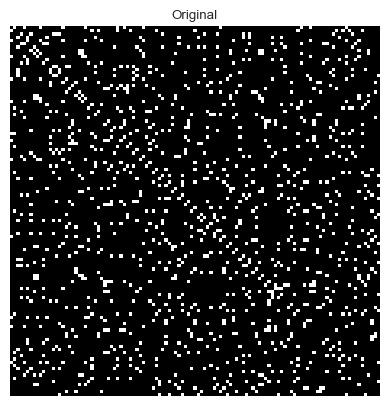

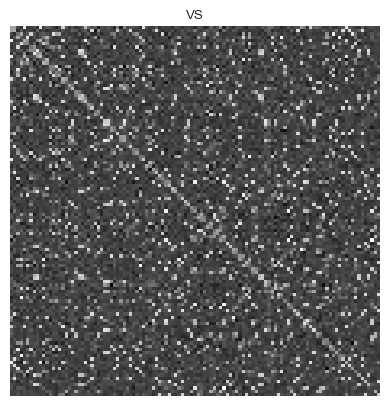

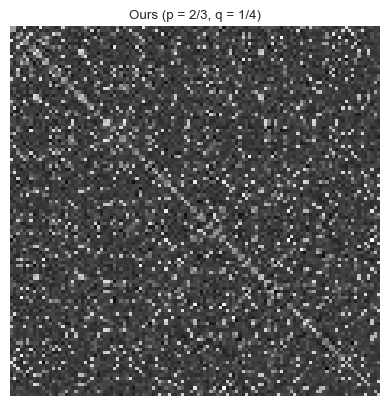

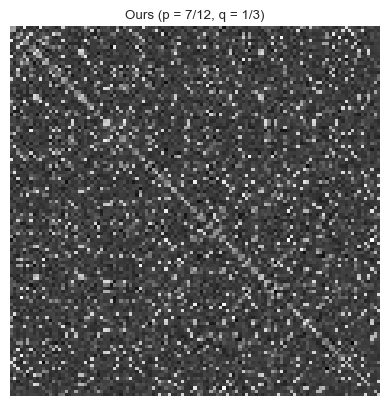

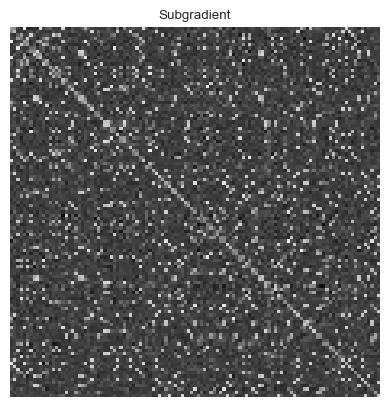

In [23]:
img = plt.imshow(D)
img.set_cmap('gray')
plt.title('Original')
plt.axis('off')
plt.show()

W, H = WHs_VS[-1]
img = plt.imshow(W@H)
img.set_cmap('gray')
plt.title('VS')
plt.axis('off')
plt.show()
# W, H = WHs_cvxNSD[-1]
# plt.imshow(norm_D*W@H)
# plt.title('Ours (CVX MNSD)')
W, H = WHs_NSD[-1]
img = plt.imshow(norm_D*W@H)
img.set_cmap('gray')
plt.title('Ours (p = 2/3, q = 1/4)')
plt.axis('off')
plt.show()

W, H = WHs_NSD2[-1]
img = plt.imshow(norm_D*W@H)
img.set_cmap('gray')
plt.title('Ours (p = 7/12, q = 1/3)')
plt.axis('off')
plt.show()

W, H = WHs_sub[-1]
img = plt.imshow(norm_D*W@H)
img.set_cmap('gray')
plt.axis('off')
plt.title('Subgradient')
plt.show()


In [24]:
W, H = WHs_NSD[-1]
s = svd(W, compute_uv=False)
# print(s)
print('Sum of the singular values for our algo', s.sum())
W, H = WHs_NSD2[-1]
s = svd(W, compute_uv=False)
# print(s)
print('Sum of the singular values for our algo2', s.sum())
W, H = WHs_VS[-1]
s = svd(W, compute_uv=False)
# print(s)
print('Sum of the singular values for the VS algo', s.sum())

Sum of the singular values for our algo 3.7764050756985768
Sum of the singular values for our algo2 3.080515825679352
Sum of the singular values for the VS algo 3.4449919753758227


### Plots

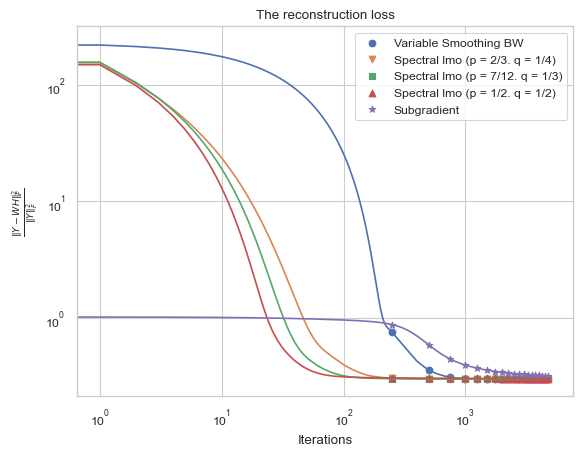

In [ ]:
scatter_period = K // 20

plt.loglog(loss_VS/norm_D)
plt.scatter(np.arange(len(loss_VS))[::scatter_period], loss_VS[::scatter_period]/norm_D, label = 'Variable Smoothing BW', marker="o")

plt.loglog(loss_NSD/norm_D)
plt.scatter(np.arange(len(loss_NSD))[::scatter_period], loss_NSD[::scatter_period]/norm_D, label = 'GAMONS (p = 2/3. q = 1/4)', marker="v")

plt.loglog(loss_NSD2/norm_D)
plt.scatter(np.arange(len(loss_NSD2))[::scatter_period], loss_NSD2[::scatter_period]/norm_D, label = 'GAMONS (p = 7/12. q = 1/3)', marker="s")

plt.loglog(loss_NSD3/norm_D)
plt.scatter(np.arange(len(loss_NSD3))[::scatter_period], loss_NSD3[::scatter_period]/norm_D, label = 'GAMONS (p = 1/2. q = 1/2)', marker="^")

plt.loglog(loss_sub/norm_D)
plt.scatter(np.arange(len(loss_sub))[::scatter_period], loss_sub[::scatter_period]/norm_D, label = 'Subgradient', marker="*")


plt.ylabel(r'$\frac{\|Y - WH\|_F^2}{\|Y\|_F^2}$')
plt.xlabel('Iterations')
plt.title('The reconstruction loss')

plt.legend()
plt.show()
    

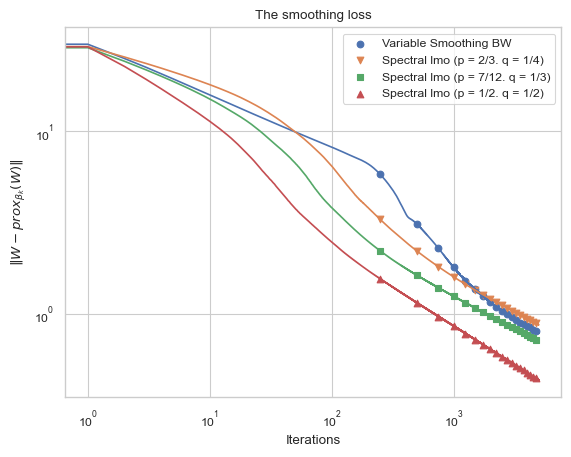

In [ ]:
plt.loglog(dist_W_prox_VS)
plt.scatter(np.arange(len(dist_W_prox_VS))[::scatter_period], dist_W_prox_VS[::scatter_period], label = 'Variable Smoothing BW', marker="o")

plt.loglog(dist_W_prox_NSD)
plt.scatter(np.arange(len(dist_W_prox_NSD))[::scatter_period], dist_W_prox_NSD[::scatter_period], label = 'GAMONS (p = 2/3. q = 1/4)', marker="v")

plt.loglog(dist_W_prox_NSD2)
plt.scatter(np.arange(len(dist_W_prox_NSD))[::scatter_period], dist_W_prox_NSD2[::scatter_period], label = 'GAMONS (p = 7/12. q = 1/3)', marker="s")

plt.loglog(dist_W_prox_NSD3)
plt.scatter(np.arange(len(dist_W_prox_NSD3))[::scatter_period], dist_W_prox_NSD3[::scatter_period], label = 'GAMONS (p = 1/2. q = 1/2)', marker="^")

plt.ylabel(r'$\|W - prox_{\beta_k}(W)\|$')
plt.xlabel('Iterations')
plt.title('The smoothing loss')

plt.legend()
plt.show()

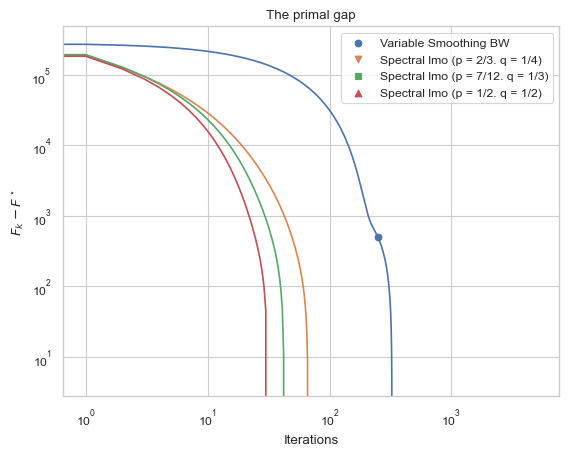

In [ ]:
ls_VS = np.zeros(K+1)
g_VS = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_VS):
    g_VS[i] = g(W)
    ls_VS[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_VS[i] - F_min
plt.loglog(ls_VS)
plt.scatter(np.arange(len(ls_VS))[::scatter_period], ls_VS[::scatter_period], label = 'Variable Smoothing BW', marker="o")

ls_NSD = np.zeros(K+1)
g_NSD = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_NSD):
    g_NSD[i] = g(W)
    ls_NSD[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_NSD[i] - F_min
plt.loglog(ls_NSD)
plt.scatter(np.arange(len(ls_NSD))[::scatter_period], ls_NSD[::scatter_period], label = 'GAMONS (p = 2/3. q = 1/4)', marker="v")

ls_NSD2 = np.zeros(K+1)
g_NSD2 = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_NSD2):
    g_NSD2[i] = g(W)
    ls_NSD[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_NSD2[i] - F_min
plt.loglog(ls_NSD)
plt.scatter(np.arange(len(ls_NSD))[::scatter_period], ls_NSD2[::scatter_period], label = 'GAMONS (p = 7/12. q = 1/3)', marker="s")

ls_NSD3 = np.zeros(K+1)
g_NSD3 = np.zeros(K+1)
for i, (W, H) in enumerate(WHs_NSD3):
    g_NSD3[i] = g(W)
    ls_NSD3[i] = np.linalg.norm(D - W@H, 'fro')**2 + g_NSD3[i] - F_min
plt.loglog(ls_NSD3)
plt.scatter(np.arange(len(ls_NSD3))[::scatter_period], ls_NSD3[::scatter_period], label = 'GAMONS (p = 1/2. q = 1/2)', marker="^")

plt.ylabel(r'$F_k - F^\star$')
plt.xlabel('Iterations')
plt.title('The primal gap')

plt.legend()
plt.show()
    

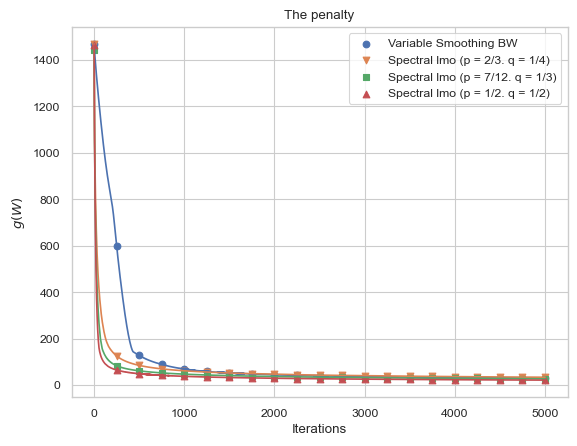

In [ ]:
plt.plot(g_VS)
plt.scatter(np.arange(len(g_VS))[::scatter_period], g_VS[::scatter_period], label = 'Variable Smoothing BW', marker="o")

plt.plot(g_NSD)
plt.scatter(np.arange(len(g_NSD))[::scatter_period], g_NSD[::scatter_period], label = 'GAMONS (p = 2/3. q = 1/4)', marker="v")

plt.plot(g_NSD2)
plt.scatter(np.arange(len(g_NSD))[::scatter_period], g_NSD2[::scatter_period], label = 'GAMONS (p = 7/12. q = 1/3)', marker="s")

plt.plot(g_NSD3)
plt.scatter(np.arange(len(g_NSD3))[::scatter_period], g_NSD3[::scatter_period], label = 'GAMONS (p = 1/2. q = 1/2)', marker="^")

plt.ylabel(r'$g(W)$')
plt.xlabel('Iterations')
plt.title('The penalty')

plt.legend()
plt.show()